In [2]:
import torch
import torch.nn as nn

import tensorflow as tf

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import cv2
import pandas as pd

import random

from sklearn.linear_model import LinearRegression

from NeuralGraph import NeuralGraph

C:\Users\Alec\AppData\Local\Temp\ipykernel_22856\1077650579.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

In [14]:
class InputIntegrator(nn.Module):
    def __init__(self, ch_inp:int=8, ch_n:int=8, ch_n_const:int=0):
        super().__init__()

        self.main = nn.Sequential(
            nn.Linear(ch_inp+ch_n, ch_n-ch_n_const),
        )

    def forward(self, x):
        return self.main(x)

class LabelIntegrator(nn.Module):
    def __init__(self, ch_out:int=8, ch_n:int=8, ch_n_const:int=0):
        super().__init__()

        self.main = nn.Sequential(
            nn.Linear(ch_out+ch_n, ch_n-ch_n_const),
        )

    def forward(self, x):
        return self.main(x)

class OutputInterpreter(nn.Module):
    def __init__(self, ch_out:int=8, ch_n:int=8):
        super().__init__()

        self.main = nn.Sequential(
            nn.Linear(ch_n, ch_out),
        )
    
    def forward(self, x):
        return self.main(x)

# class Message(nn.Module):
#     def __init__(self, ch_n:int=8, ch_e:int=8, ch_n_const:int=0, ch_e_const:int=0):
#         super().__init__()

#         self.main = nn.Sequential(
#             nn.Linear(ch_n*2 + ch_e, 2 * ((ch_n-ch_n_const)*2 + (ch_e-ch_e_const))),
#             nn.ReLU(),
#         )
#     def forward(self, x):
#         outs = self.main(x)
#         return outs[..., :outs.shape[-1]//2] - outs[..., outs.shape[-1]//2:]

class Message(nn.Module):
    def __init__(self, ch_n:int=8, ch_e:int=8, ch_n_const:int=0, ch_e_const:int=0):
        super().__init__()

        self.main = nn.Sequential(
            nn.Linear((ch_n*2 + ch_e) + int((ch_n*2 + ch_e) * ((ch_n*2 + ch_e) - 1) / 2), (ch_n-ch_n_const)*2 + (ch_e-ch_e_const)),
        )
    def forward(self, x):

        # print(x.unsqueeze(-1).shape, x.unsqueeze(-2).shape, (x.unsqueeze(-1) @ x.unsqueeze(-2)).shape)
        # inp = (x.unsqueeze(-1) @ x.unsqueeze(-2)).reshape(*x.shape[:-1], x.shape[-1]**2)
        inp = torch.cat([x, *[x[..., i:i+1] * x[..., j:j+1] for i in range(x.shape[-1]) for j in range(i+1, x.shape[-1])]], dim=-1)
        outs = self.main(inp)
        return outs

class Update(nn.Module):
    def __init__(self, ch_n:int=8, ch_n_const:int=0):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Linear(ch_n + (ch_n - ch_n_const)*2, (ch_n - ch_n_const)),
        )
    def forward(self, x):
        return self.main(x)

In [42]:
device = "cpu"

BATCH_SIZE = 16
TIME = 1
DT = .25

n_inps = 8
n_outs = 8

n_nodes = n_inps + n_outs
connections = [(i, j) for i in range(n_nodes) for j in range(n_nodes)]

print(len(connections))

graph = NeuralGraph(n_nodes, n_inps, n_outs, connections,
    ch_n=3, ch_e=3, value_init="trainable", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="none", decay=1,
    device=device, n_models=1, label_int_generator=LabelIntegrator, inp_int_generator=InputIntegrator, 
    out_int_generator=OutputInterpreter, message_generator=Message, update_generator=Update,
    )

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

log = []

256


In [16]:
graph.load("direct_memorize.pt")

RuntimeError: Error(s) in loading state_dict for NeuralGraph:
	size mismatch for messages.0.main.0.weight: copying a param with shape torch.Size([9, 81]) from checkpoint, the shape in current model is torch.Size([9, 45]).

### Memorize Task
##### Repeat input/output pairs in order they're given

In [43]:
STEPS = 100_000
EXAMPLES = 5

In [44]:
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

_lambda = 0

bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.randn(BATCH_SIZE, EXAMPLES, n_inps, device=device)
    y_train = torch.randn(BATCH_SIZE, EXAMPLES, n_outs, device=device)# torch.randint(2, size=(BATCH_SIZE, EXAMPLES, n_outs), device=device).float()

    # graph.detach_vals()
    optimizer.zero_grad()


    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    
    # for i in range(EXAMPLES):
    #     graph.backward(x_train[:, i], y_train[:, i], nodes=True, edges=True, time=TIME, dt=DT)
    graph.learn(x_train, y_train, time=TIME, dt=DT)
    
    indices = np.arange(EXAMPLES)
    np.random.shuffle(indices)
    indices = torch.Tensor(indices).long()

    pred = graph.predict(x_train[:, indices], time=TIME, dt=DT)

    task_loss = criterion(pred, y_train[:, indices])
    overflow = graph.overflow(2)

    l1 = torch.cat([
        graph.inp_int.main[0].weight.flatten(),
        graph.out_int.main[0].weight.flatten(),
        graph.label_int.main[0].weight.flatten(),
        graph.messages[0].main[0].weight.flatten(),
        graph.updates[0].main[0].weight.flatten()
    ]).abs().mean()

    loss = task_loss + overflow + _lambda * l1
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    if not torch.isnan(overflow) and overflow < 1 and graph.decay > .001:
        # print(overflow, graph.decay)
        graph.decay -= .001

    entry = {'loss': task_loss.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "overflow":entry["overflow"], "Decay":graph.decay, "l1":l1.item()})

  0%|          | 0/100000 [00:00<?, ?it/s]

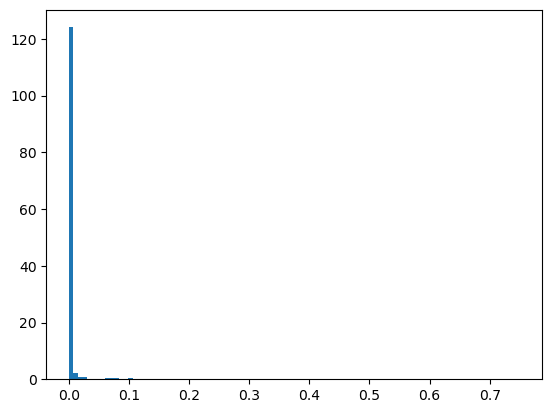

tensor(90)
tensor(0.0556)


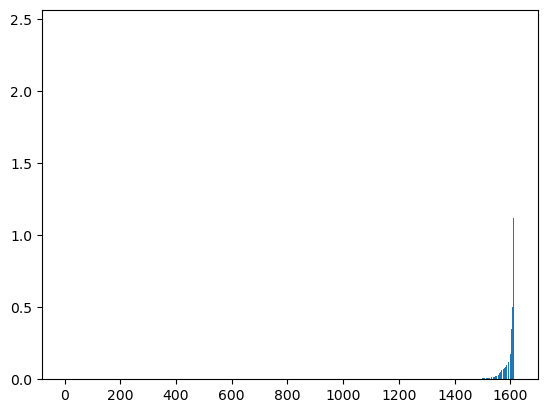

In [496]:
ps = torch.cat([p.flatten() for p in graph.parameters()]).abs().detach()

_, _, _ = plt.hist(ps, bins=np.linspace(0, .75, 100), density=True)
plt.show()
print(torch.where(ps > .01, 1, 0).sum())
print(torch.where(ps > .01, 1, 0).sum() / len(ps))

plt.bar(np.arange(len(ps)), np.sort(ps))
plt.show()

In [497]:
graph.save("direct_memorize.pt")

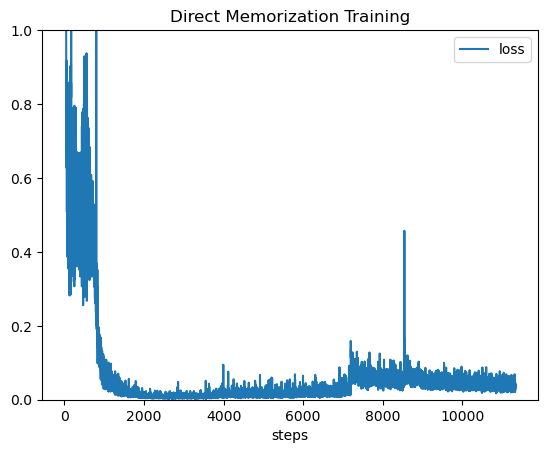

In [498]:
plt.title("Direct Memorization Training")

plt.plot([e['loss'] for e in log], label="loss")
plt.legend()
plt.xlabel("steps")
plt.ylim(0, 1)

# plt.savefig("direct_memorize.png", dpi=500)
plt.show()
# graph.save("models/direct_memorize.pt")

In [499]:
print(np.sum([np.prod([*p.shape]) for p in graph.parameters()]))

1618


In [500]:
def norm(x):
    if isinstance(x, torch.Tensor):
        return (x - x.min()) / (x.max() - x.min())
    else:
        return (x - np.min(x)) / (np.max(x) - np.min(x))

In [501]:
print(graph.init_nodes.shape)

torch.Size([16, 3])


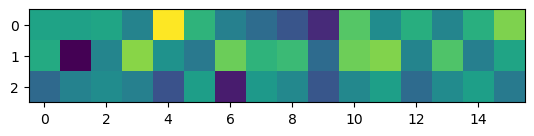

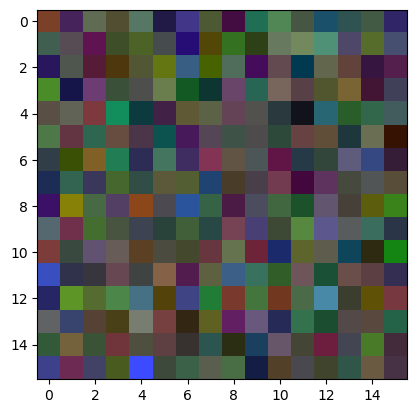

In [502]:
plt.imshow(norm(graph.init_nodes.detach()).T)
plt.show()

plt.imshow(norm(graph.init_edges.detach()).reshape(16, 16, -1))
plt.show()

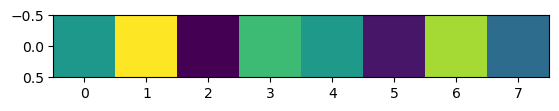

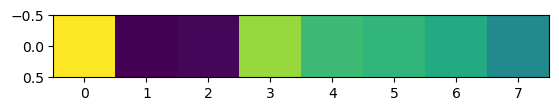

In [503]:
examples = 1
x_train = torch.randn(1, examples, n_inps, device=device)
y_train = torch.randn(1, examples, n_outs, device=device)

# x_train = torch.Tensor([[[0, 0.33, 0.66, 1, 1, 0.66, .33, 0]]]).to(device)

# y_train = torch.Tensor([[[0, -0.33, -0.66, -1, 1, 0.66, .33, 0]]]).to(device)

plt.imshow(x_train.reshape(examples, n_inps))
plt.show()

plt.imshow(y_train.reshape(examples, n_inps))
plt.show()

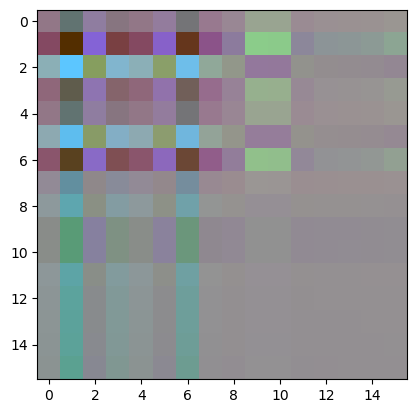

In [504]:
# ch = 0

graph.init_vals(nodes=True, edges=True, batch_size=1)
graph.learn(x_train, y_train, time=TIME, dt=DT)

diff = (graph.edges.detach().squeeze(0) - graph.init_edges.detach())

plt.imshow(norm(diff).reshape(16, 16, 3))
plt.show()

In [505]:
connections = torch.Tensor([[i, j] for i, j in connections]).to(device).long()
inp_inp = np.arange(256).reshape(16, 16)[:8, :8].reshape(-1)
out_inp = np.arange(256).reshape(16, 16)[8:, :8].reshape(-1)
inp_out = np.arange(256).reshape(16, 16)[:8, 8:].reshape(-1)
out_out = np.arange(256).reshape(16, 16)[8:, 8:].reshape(-1)

inp_inp
(64, 7) (64, 3)
[[-2.6832238e-02 -5.5110693e-01 -3.8857082e-01]
 [-2.2939570e-01 -3.9079443e-02 -1.7824988e-01]
 [-1.7839940e-02 -2.1926138e-01 -8.8926935e-01]
 [ 6.0238797e-02 -9.5603960e-03 -1.2702556e-02]
 [ 1.5606347e-01 -6.7154421e-03  7.8118982e-04]
 [-5.4422118e-05  1.3982430e-03 -1.5850971e-03]
 [-1.4263058e-01 -2.8956872e-01 -9.4587229e-02]]


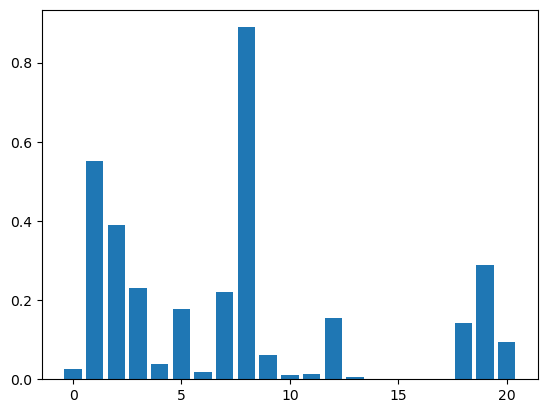

0.0026256964
0.20168747


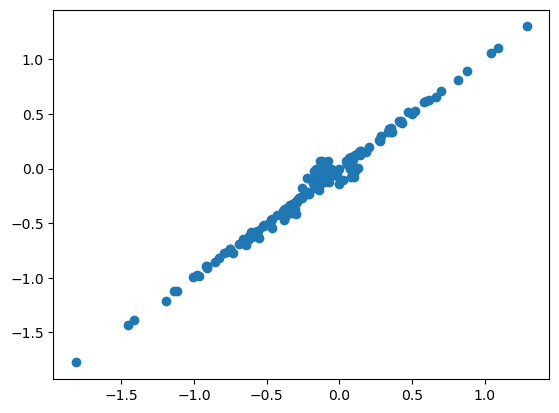

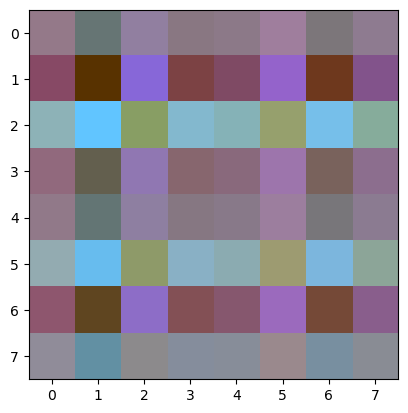

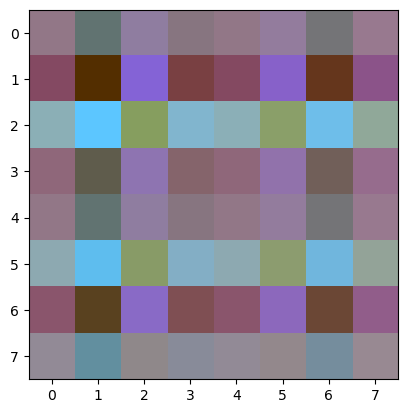

out_inp
(64, 7) (64, 3)
[[ 3.7003373e-04 -4.9193000e-04  3.4287004e-06]
 [-2.2291422e-01  1.2622903e-01  2.1266192e-02]
 [ 1.5167402e-04 -6.8471173e-04  1.1774346e-02]
 [ 2.5015760e-02  7.5526029e-02  9.8759554e-02]
 [ 1.5637788e-01 -1.6377851e-02  6.2768436e-03]
 [ 2.4354791e-04 -3.0105710e-03  1.6291244e-02]
 [-1.7848708e-01  2.5370210e-02  2.2485584e-02]]


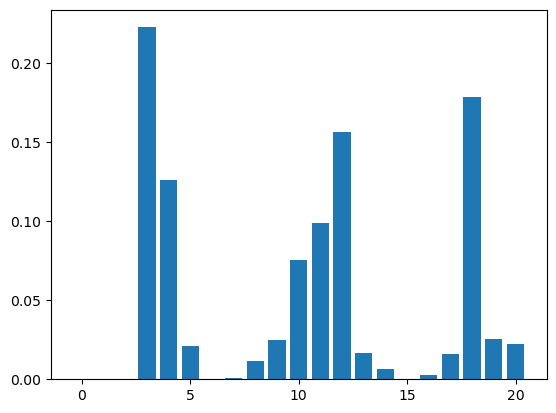

0.0064683505
0.03554422


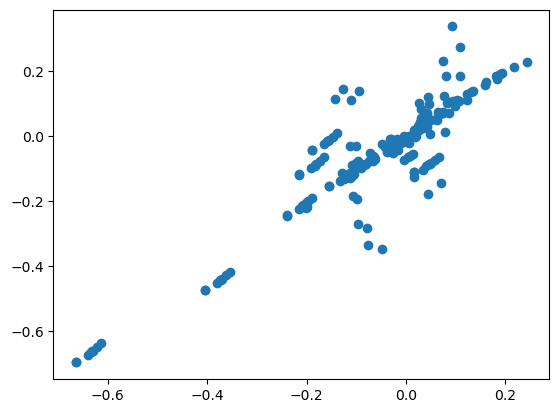

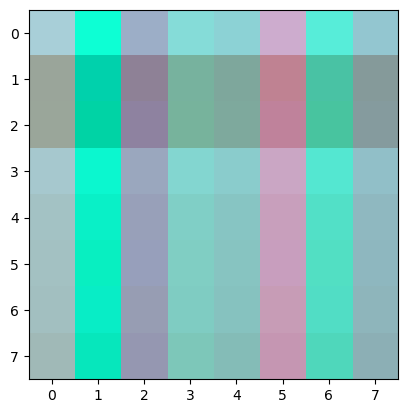

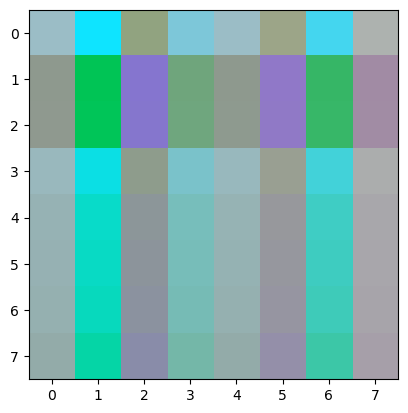

inp_out
(64, 7) (64, 3)
[[-3.1922638e-02  1.2292909e-01  9.4708214e-03]
 [-2.6318536e-04 -9.4184215e-05  2.4492102e-04]
 [ 4.3866161e-04 -1.5691537e-02  5.3410418e-03]
 [ 6.0382925e-02 -1.0884716e-02 -3.9545940e-03]
 [ 1.7085950e-03 -1.5878481e-01  1.0765679e-02]
 [ 6.0084451e-04 -2.1647779e-02  8.2456451e-03]
 [ 4.3428000e-02 -2.2586381e-02 -9.7849860e-04]]


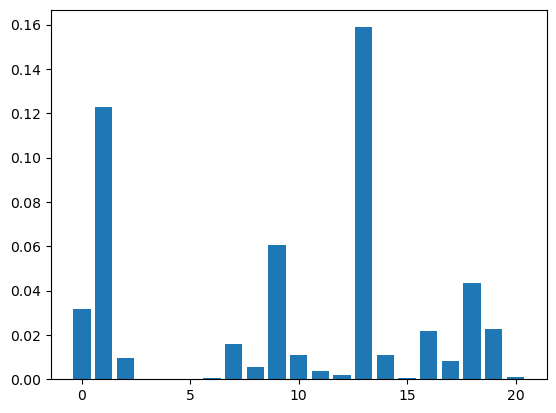

0.008831753
0.016295493


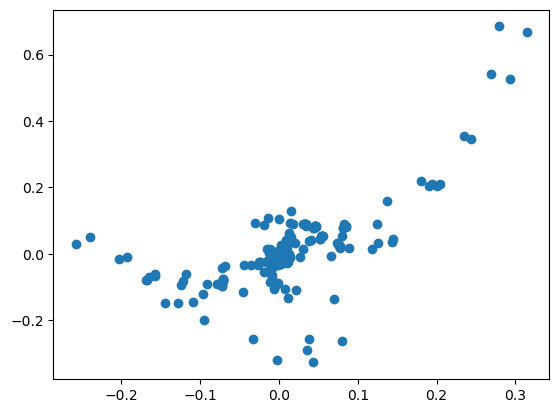

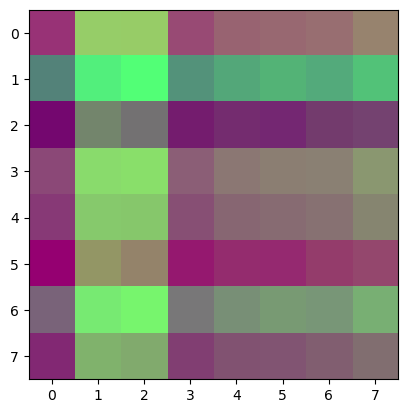

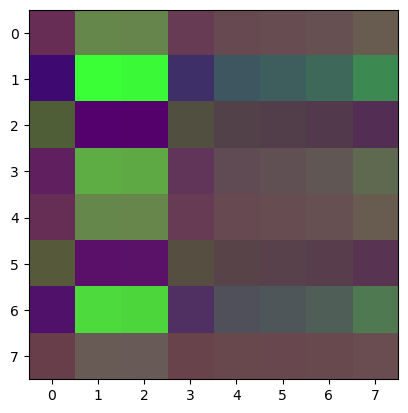

out_out
(64, 7) (64, 3)
[[ 3.7048542e-04 -5.3021580e-04 -4.8169801e-05]
 [-2.6461482e-04 -9.3736686e-05  2.0823076e-04]
 [-3.2963453e-07  9.3277777e-09 -5.9691774e-07]
 [ 2.4675263e-02  3.3411112e-02 -6.8080518e-03]
 [-2.2303755e-03 -7.4527720e-03 -1.5323798e-02]
 [-8.5351389e-04  3.3557735e-02 -2.7099220e-02]
 [ 9.5973620e-03 -4.1960664e-02 -8.5188020e-03]]


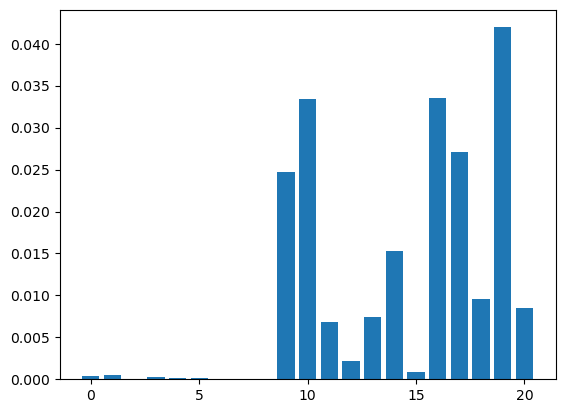

5.136488e-06
0.0008679845


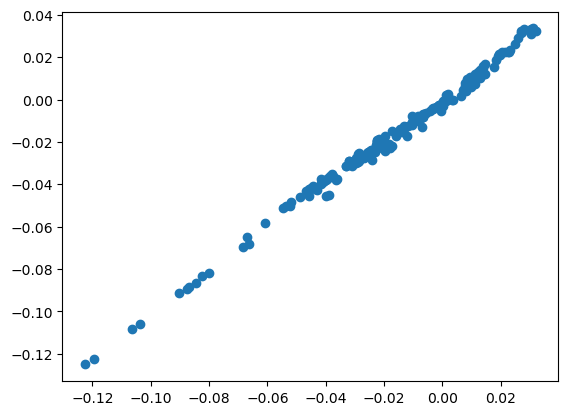

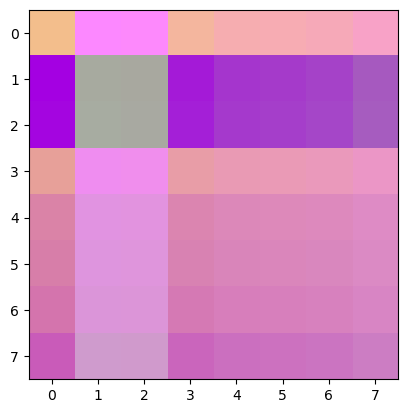

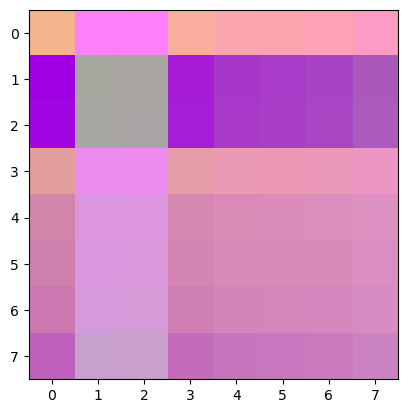

In [506]:
# ch = 0

edge_sets = {
    "inp_inp":inp_inp,
    "out_inp":out_inp,
    "inp_out":inp_out,
    "out_out":out_out,
}

for name, edge_set in edge_sets.items():
    print(name)



    X = torch.stack([x_train[0, 0, connections[edge_set, 0] % 8], x_train[0, 0, connections[edge_set, 1] % 8], 
                    x_train[0, 0, connections[edge_set, 0] % 8] * x_train[0, 0, connections[edge_set, 1] % 8],
                    y_train[0, 0, connections[edge_set, 0] % 8], y_train[0, 0, connections[edge_set, 1] % 8], 
                    y_train[0, 0, connections[edge_set, 0] % 8] * y_train[0, 0, connections[edge_set, 1] % 8],

                    torch.ones(len(edge_set))], axis=1).numpy()

    Y = diff[edge_set].numpy()
    print(X.shape, Y.shape)

    w = np.linalg.inv(X.T @ X) @ X.T @ Y

    y_pred = X @ w

    print(w)
    plt.bar(np.arange(len(w.flatten())), np.abs(w).flatten())
    plt.show()

    print(np.mean(np.square(Y - y_pred)))

    print(np.mean(np.square(Y - np.mean(Y))))

    # diff[inp_inp, 0]

    plt.scatter(y_pred.flatten(), Y.flatten())
    plt.show()

    plt.imshow(norm(y_pred).reshape(8, 8, 3))
    plt.show()
    plt.imshow(norm(Y).reshape(8, 8, 3))
    plt.show()
    # plt.imshow(norm(Y-y_pred).reshape(8, 8, 3))
    # plt.show()

In [507]:
inp_w = graph.inp_int.main[0].weight.detach()
lbl_w = graph.label_int.main[0].weight.detach()
out_w = graph.out_int.main[0].weight.detach()
msg_w = graph.messages[0].main[0].weight.detach()
udt_w = graph.updates[0].main[0].weight.detach()

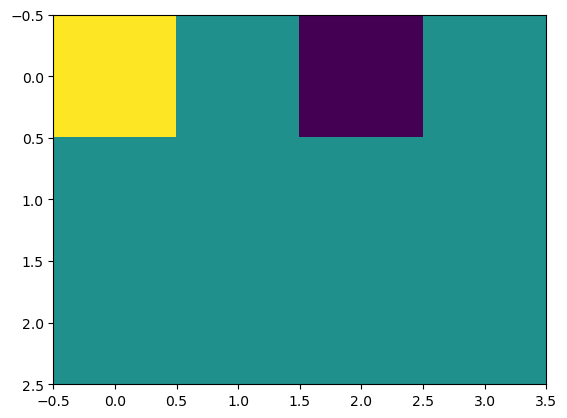

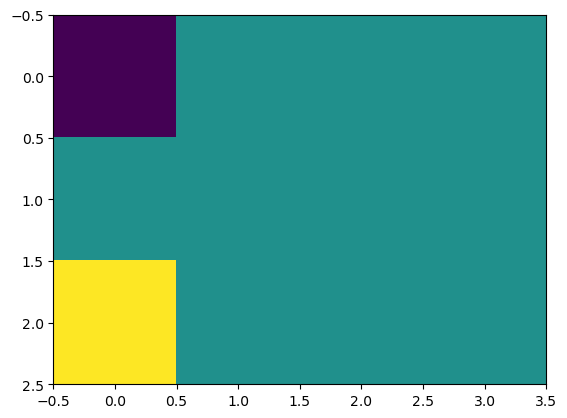

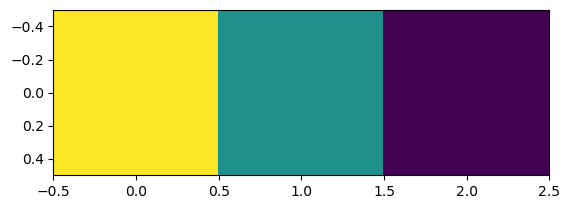

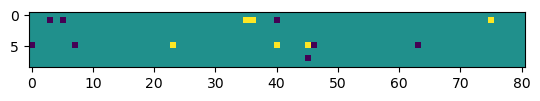

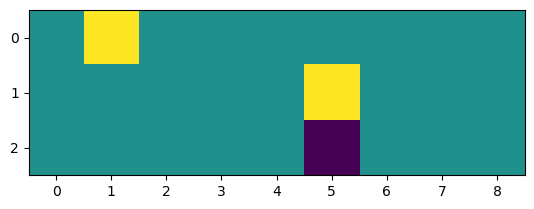

In [508]:
def bit(w, thresh=.2):
    return torch.where(w.abs() > thresh, torch.sign(w), 0)

plt.imshow(bit(inp_w, .2)/2+.5)
plt.show()
plt.imshow(bit(lbl_w, .2)/2+.5)
plt.show()
plt.imshow(bit(out_w, .2)/2+.5)
plt.show()
plt.imshow(bit(msg_w, .1)/2+.5)
plt.show()
plt.imshow(bit(udt_w, .2)/2+.5)
plt.show()

In [509]:
ops = [f"n_a[{i}]" for i in range(3)] + [f"n_b[{i}]" for i in range(3)] + [f"e[{i}]" for i in range(3)]
inps = [ops[i//len(ops)] + " * " + ops[i % len(ops)] for i in range(len(ops)**2)]
# print(inps)
outs = [f"m_a[{i}]" for i in range(3)] + [f"m_b[{i}]" for i in range(3)] + [f"e_m[{i}]" for i in range(3)]

In [510]:
for i, j in torch.argwhere(bit(msg_w, .15).abs() == 1):
    print(outs[i], inps[j])

# m_a[1] = 

m_a[1] n_b[0] * e[2]
m_a[1] n_b[1] * n_a[0]
m_a[1] e[2] * n_b[0]
m_b[2] n_a[0] * e[1]
m_b[2] n_a[2] * n_b[2]
m_b[2] e[1] * n_a[0]


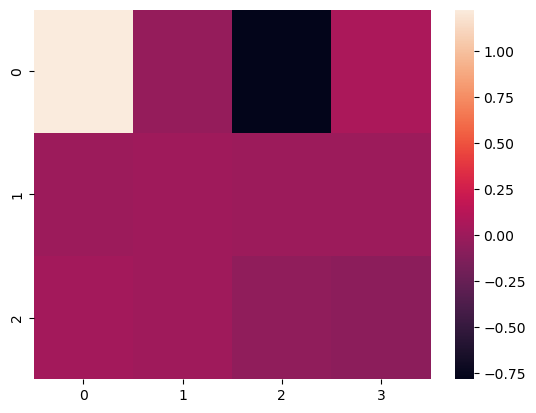

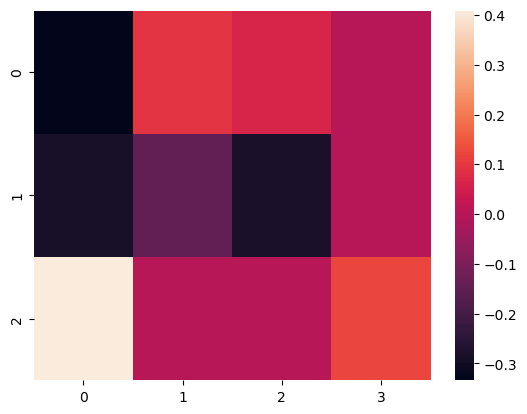

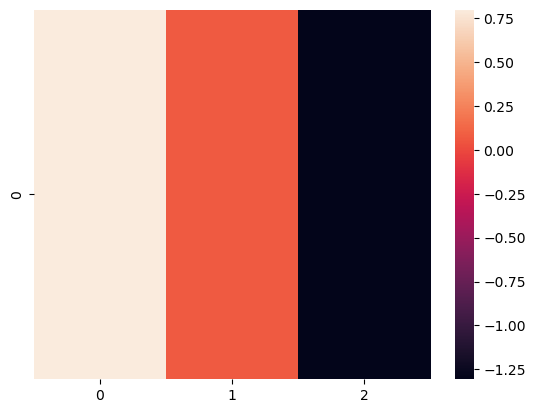

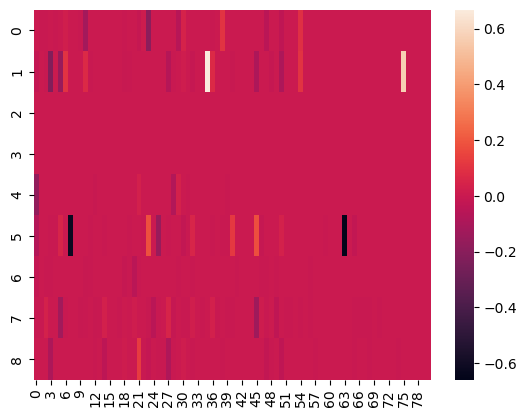

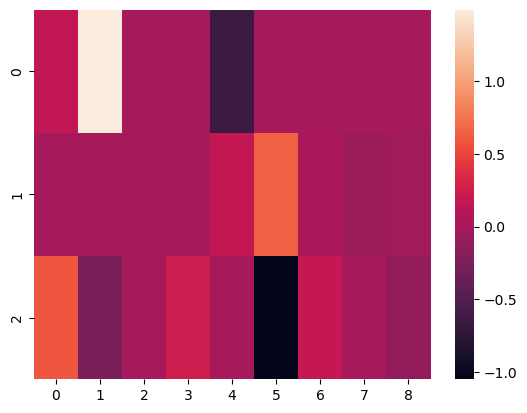

In [461]:
sb.heatmap(graph.inp_int.main[0].weight.detach())
plt.show()
sb.heatmap(graph.label_int.main[0].weight.detach())
plt.show()
sb.heatmap(graph.out_int.main[0].weight.detach())
plt.show()
sb.heatmap(graph.messages[0].main[0].weight.detach())
plt.show()
sb.heatmap(graph.updates[0].main[0].weight.detach())
plt.show()

In [115]:
INP_SIZE = 8
OUT_SIZE = 2
BATCH_SIZE = 16
TIME = 1
DT = .5

device = "cuda" if torch.cuda.is_available() else "cpu"


# shape = [SIZE**2, n_classes]
n_nodes = INP_SIZE + OUT_SIZE
connections = [(i, j) for i in range(n_nodes) for j in range(n_nodes)]

print(len(connections))

graph = NeuralGraph(n_nodes, INP_SIZE, OUT_SIZE, connections,
    ch_n=4, ch_e=4, value_init="trainable", init_value_std=.05, 
    aggregation="mean", use_label=True, clamp_mode="soft", max_value=1e5, n_models=2,
    device=device, label_int_generator=LabelIntegrator, inp_int_generator=InputIntegrator, 
    out_int_generator=OutputInterpreter, message_generator=Message, update_generator=Update)

log = []

STEPS = 3_000
EXAMPLES = 5

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, STEPS)

100


In [116]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, EXAMPLES, INP_SIZE, device=device)# torch.zeros(BATCH_SIZE, EXAMPLES, SIZE**2, device=device)
    y_train = torch.randint(OUT_SIZE, size=(BATCH_SIZE, EXAMPLES), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, OUT_SIZE).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)
    pred = graph.predict(x_train, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

    acc = (pred.argmax(2) == y_train).float().mean()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    entry = {'loss': task_loss.item(), 'acc': acc.item(), "overflow": overflow.item()}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"]})

  0%|          | 0/3000 [00:00<?, ?it/s]

KeyboardInterrupt: 

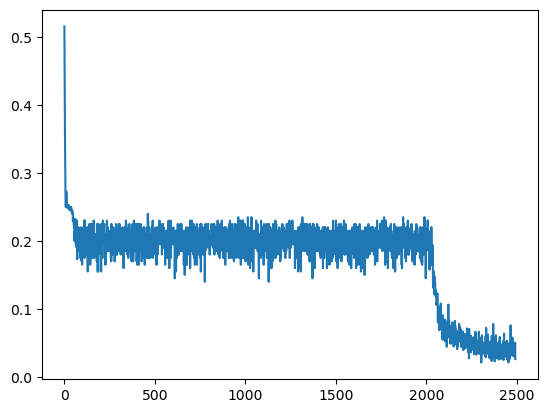

In [117]:
plt.plot([l['loss'] for l in log])

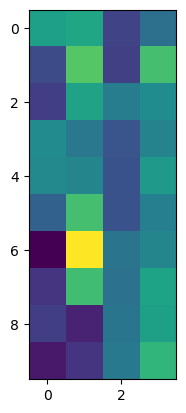

In [118]:
plt.imshow(graph.init_nodes.detach())
plt.show()

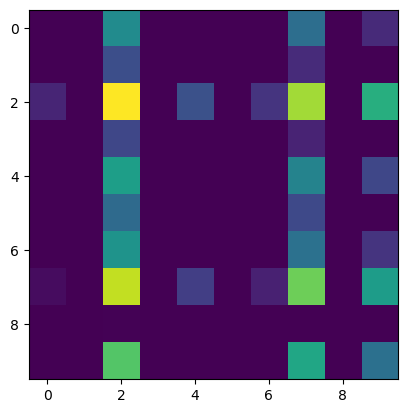

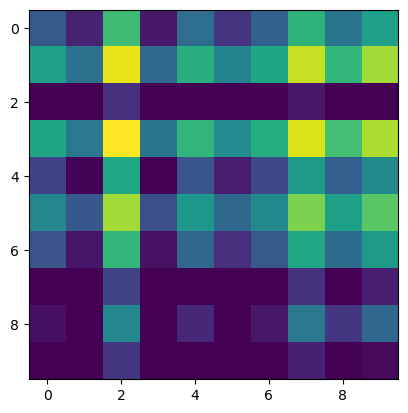

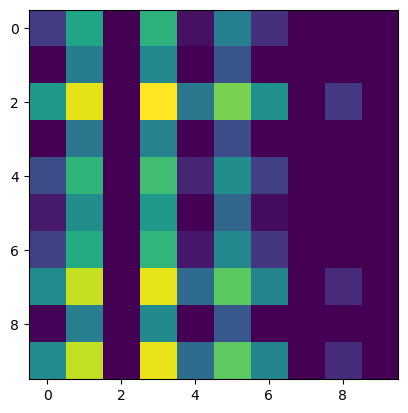

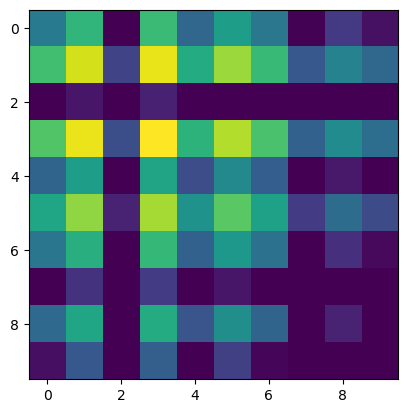

In [132]:
examples = 1

graph.init_vals(batch_size=1)
inp = torch.rand(1, examples, INP_SIZE, device=device)# torch.zeros(BATCH_SIZE, EXAMPLES, SIZE**2, device=device)
label = torch.randint(OUT_SIZE, size=(1, examples), device=device)
label_input = nn.functional.one_hot(label, OUT_SIZE).float()

# print(inp.shape, label_input.shape, label.shape)

graph.learn(inp, label_input, time=TIME, dt=DT, apply_once=True, reset_nodes=True)

ch = 0
for ch in range(4):
    plt.imshow((graph.edges - graph.init_edges)[:, :, ch].reshape(n_nodes, n_nodes).detach())
    plt.show()

In [121]:
print(connections[-18:])

[(8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


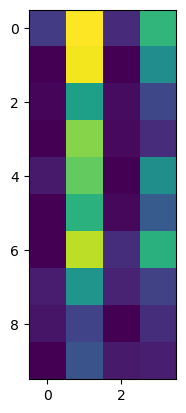

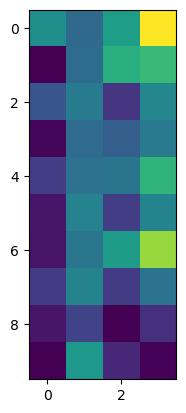

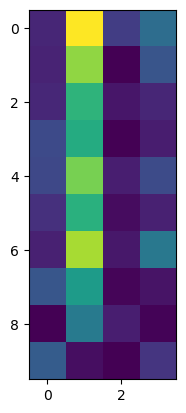

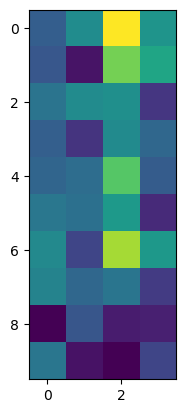

In [123]:
plt.imshow((graph.edges - graph.init_edges)[0, 8::10].detach())
plt.show()
plt.imshow((graph.edges - graph.init_edges)[0, -20:-10].detach())
plt.show()


plt.imshow((graph.edges - graph.init_edges)[0, 9::10].detach())
plt.show()
plt.imshow((graph.edges - graph.init_edges)[0, -10:].detach())
plt.show()

tensor([0.6536, 0.8985, 0.2226, 0.9389, 0.5897, 0.8120, 0.6325, 0.2815])
tensor([1., 0.])


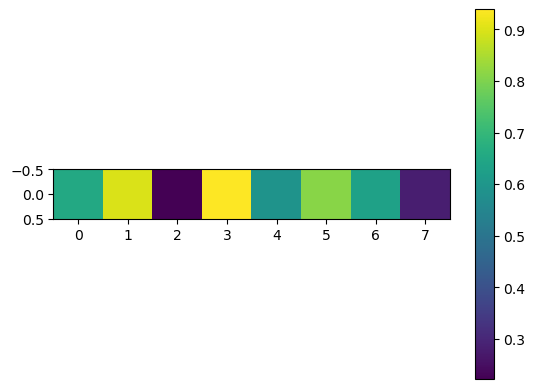

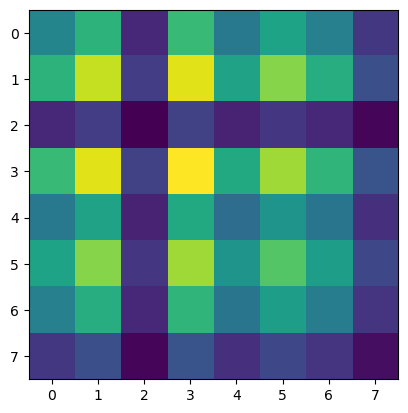

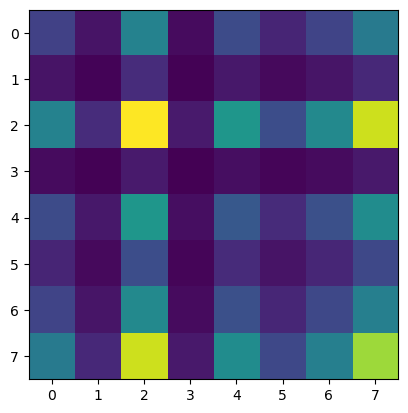

In [133]:
print(inp[0][0])
print(label_input[0][0])
plt.imshow(inp[0])
plt.colorbar()
plt.show()
plt.imshow(inp[0][0].outer(inp[0][0]))
plt.show()
plt.imshow((1-inp[0][0]).outer(1-inp[0][0]))
plt.show()

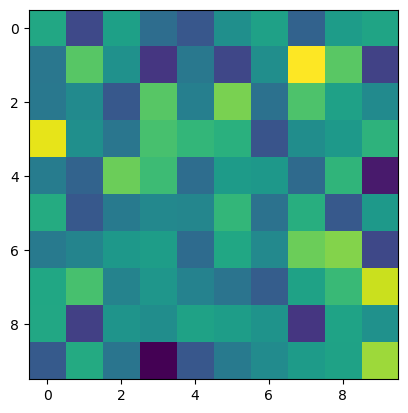

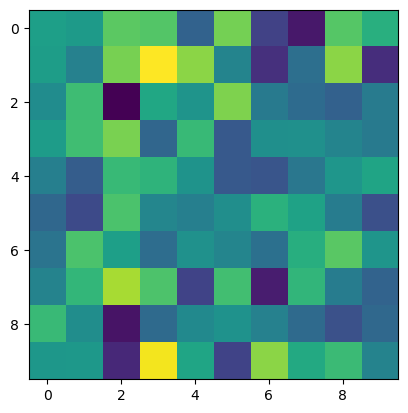

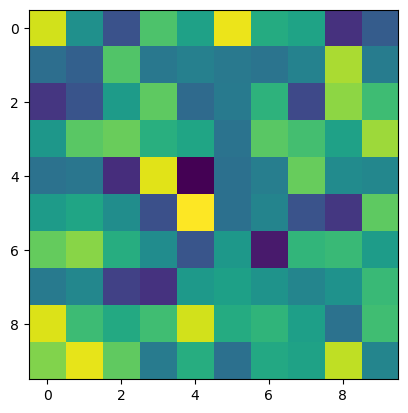

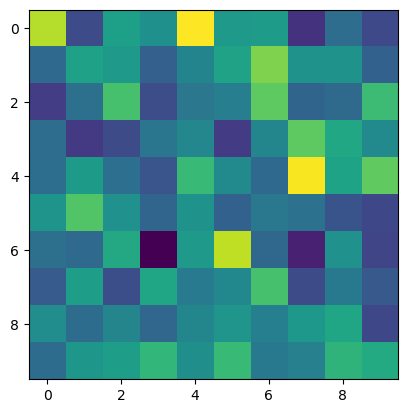

In [126]:
for ch in range(4):# ch = 0
    plt.imshow(graph.init_edges[:, ch].reshape(n_nodes, n_nodes).detach())
    plt.show()